# Integral Windup and Bumpless Transfer

> "the devil is in the details" -- anonymous

> "and everything is detail" -- military expression

## Learning Goals

Up to this point we have been giving a "textbook" introduction to proportional-integral (PI) control. There is a world of difference between "textbook" and "practical". 

* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * What is reset windup?
         * Fix 1: Insert limits on the manipulated variable (MV)
         * Fix 2: If possible, get field measurements of the manipulated variable (MV)
    * Bumpless Transfer
         * What is bumpless transfer?
         * Manual to Auto transition

## Glossary of terms

Process control is full of specialized jargon for describing control systems and their performance. Here are some terms relevant to PID control.

:::{glossary}

P&ID 
  Piping and Instrumentation Diagrams showing type and placement of sensors, controllers, actuators, and other instruments used in process control. A typical encoding is given XY where 

  | X | Variable |
  | :---: | :---: |
  | F | Flow |
  | L | Level |
  | P | Pressure | 
  | T | Temperature |

  | Y | Instrument Type |
  | :---: | :---: |
  | T | Transmitter |
  | G | Gauge |
  | I | Indicator |
  | IC | Indicating Controller |
  
PID
  Proportional-Integral-Derivative Control

PV
  Process Variable. Generally a variable that is measured and used for feedback control. Typical examples are flow, level, pressure, and temperature, but may include composition, displacement, and many other variable types.

MV
  Manipulated Variable. The variable being manipulated by the controller. Typically a flowrate using a control valve.

SP
  Setpoint Variable. A desired value for process variable (PV). The job of the controller is change MV to cause PV to become equal to SP.

Reset-windup (also call Integral windup)
  Reset-Windup refers to changes in the manipulated variable (MV) caused by specifying an infeasible setpoint. An example would be a setpoint of 120 degrees C for a heater that can reach a maximum temperature of only 100 deg C, or a setpoint of 10 deg C below ambient temperature when no cooling is available. In these situation the error signal (PV - SP) can never return to zero which causes the integration of the error signal to "wind-up".

Anti-reset-windup
  A modification to the standard PI and PID control algorithms to (1) avoid out-of range values of the manipulated variables (MV), and (2) incorporate field measurements of the manipulated variable. Anti-reset-windup avoids infeasible values of the manipulated variable due to infeasible setpoints or situations where the actuator is not responding to inputs.

Bumpless transfer
  A modification to the standard PI and PID control algorithms to avoid sudden jumps in manipulated variable when switching from manual to automatic control. 
  
:::

## Typical P&ID Diagram for PI and PID control.

![](https://cdn.instrumentationtools.com/wp-content/uploads/2020/01/Identify-Process-Variables-in-PID.png)

---
**Study Question:** Carefully review the following P&ID diagrams. Locate the control loops, identify the sensors, controls, and actuators.  

* [Example](https://d2slcw3kip6qmk.cloudfront.net/marketing/pages/chart/seo/piping-instrumentation/p-id-example-diagram.svg) Notice the sensors are not clearly shown. Modify this diagram to show the sensors and transmitters.
* [Distillation Unit](https://www.rff.com/process-and-instrument-drawing.png)
* [A complete unit operation](https://pressbooks.bccampus.ca/chbe220/wp-content/uploads/sites/1010/2020/06/PIDExp.png)
---

## Basic PI Control

Proportional-Integral (PI) Control in velocity form is given by

\begin{align}
MV_k & = MV_{k-1} + K_P (e_{k} - e_{k-1}) + \delta t K_I e_k
\end{align}

where $MV_0= \bar{MV}$ is the initial value, and the error $e_k$ is the difference between the process variable and setpoint, and $\delta t$ is the time step.

\begin{align}
e_k & = SP_k - PV_k \\
\end{align}

and $\delta t$ is the time step.

We encode the controller using the Python `yield' statement. The implementation has added `t_step` to facilitate use of this code for situations where we may change the time step or have a variable time step.

In [1]:
def PI(Kp, Ki, MV_bar=0):
    ''' Primative "textbook" PI controller in velocity form

    This is NOT the final version of our PI controller.
    
    Arguments:
        Kp: proportional gain
        Ki: integral gain
        MV_bar: bias (default 0)
    
    Usage:
        controller = PI(Kp, Ki, MV_bar)
        t_step, SP, PV = next(controller)
        MV = controller.send([t_step, SP, PV])

    '''
    # Initialize MV with bias value (MV_bar)
    MV = MV_bar

    # Initialize previous error as 0
    e_prev = 0

    # Infinite loop
    while True:
        # Yield MV and wait for new t_step, SP, PV
        t_step, SP, PV = yield MV

        # Calculate error
        e = SP - PV

        # Adjust MV using PI velocity form
        MV += Kp*(e - e_prev) + t_step*Ki*e

        # Saturate MV (apply bounds of 0 and 100)
        # (disabled for now, will be re-enabled in the final version of the controller)
        # MV = max(0, min(100, MV))

        # Update previous error
        e_prev = e
        

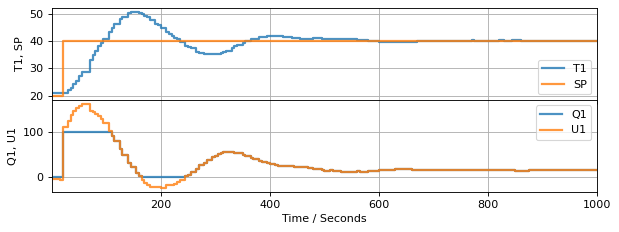

TCLab Model disconnected successfully.


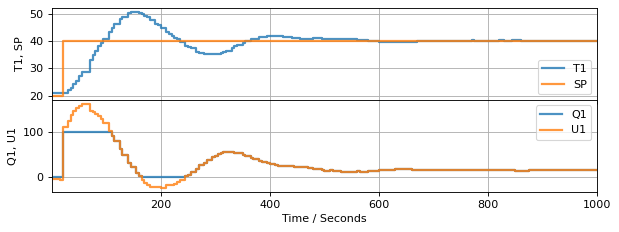

In [2]:
from tclab import TCLab, clock, Historian, Plotter, setup

def SP(t):
    ''' Step test setpoint profile '''
    return 40 if t >= 20 else 20

def DV(t):
    ''' Disturbance profile '''
    return 100 if t >= 420 else 0

# Connect to TCLab (simulate/digital twin in connected=False)
TCLab = setup(connected=False, speedup=60)

# Specify time horizon and time step (seconds)
t_final = 1000
t_step = 5

# Create a controller
controller = PI(Kp=5, Ki=0.2)

with TCLab() as lab:
    # Create a historian to store data
    sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
               ("U1", lambda: U1), ("Q1", lab.Q1))
    h = Historian(sources)
    p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

    # initialize maximum heater power (recall 255 is maximum)
    lab.P1 = 200
    lab.P2 = 200

    # Apply first step of controller
    lab.Q1(next(controller))

    # event loop over time
    for t in clock(t_final, t_step):
        # read temperature
        T1 = lab.T1

        # calculate controll action
        U1 = controller.send((t_step, SP(t), T1))

        # apply control action
        lab.Q1(U1)

        # apply disturbance
        lab.Q2(DV(t))

        # update plot
        p.update(t)

## Sequence Diagram for TCLab

![](figures/sequence-PID-1.png)

The benefits of using the `yield` statement is that we can use the same code to create multiple instances of controller, each with it's own parameters and state. The communication between the main event loop and a controller instance is illustrated in this diagram:

![](https://jckantor.github.io/cbe30338-2021/figures/controller-coroutine.png)

The following cells demonstrate performance of the controller when subject to a step change in setpoint and a disturbance input.

## What is Integral/Reset Windup?

Let's increase the magnitude of the control gains to see if we an acheive even better control performance.

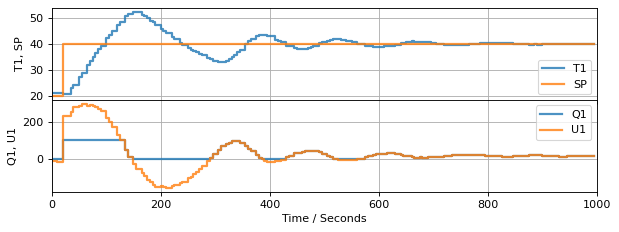

TCLab Model disconnected successfully.


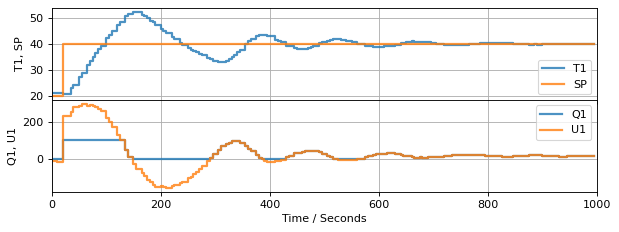

In [3]:
# Create new controller
controller = PI(Kp=10, Ki=0.5)

with TCLab() as lab:
    # Create a historian to store data
    sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
               ("U1", lambda: U1), ("Q1", lab.Q1))
    h = Historian(sources)
    p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

    # Initialize maximum heater power (recall 255 is maximum)
    lab.P1 = 200
    lab.P2 = 200

    # Apply first step of controller
    lab.Q1(next(controller))

    # event loop over time
    for t in clock(t_final, t_step):
        # Measure temperature
        T1 = lab.T1

        # Calculate control action
        U1 = controller.send((t_step, SP(t), T1))

        # Apply control action
        lab.Q1(U1)

        # Apply disturbance
        lab.Q2(DV(t))

        # Update plot
        p.update(t)

---

**Discussion Question:** Examine the results of this experiment. The PI velocity algorithm is given by an equation

\begin{align}
MV_{k} & = MV_{k-1} + K_p(e_{k} + e_{k-1}) + \delta t K_i e_{k}
\end{align}

Looking at the period from 0 to 100 seconds, is this equation describing what is actually happening? Is it possible for $MV$ to be different from the actual input applied to the device?

---

Integral (also called Reset) windup is a consequence the controller computing values for the manipulable input that are outside the range of feasible values. The difference is due to the presence of upper and lower bounds on the manipulated variable.

### Anti-Reset Windup: Type 1

There several common strategies for avoiding integral (reset) windup. The first of these should be part of any practical implementation. The technique is to limit computed values of manipulated variable to the range of values that can be implemented. This will avoid $MV$ 'winding up' due to range limits.

$$
\begin{align}
\hat{MV}_{k} & = MV_{k-1} + K_p(e_{k} + e_{k-1}) + \delta t K_i e_{k} 
\end{align}
$$

$$
\begin{align}
MV_k & = \begin{cases}
MV^{min} & \text{if } \hat{MV}_k \leq MV^{min}\\
\hat{MV}_k & \text{if } MV^{min} \leq \hat{MV}_k \leq MV^{max}\\
MV^{max} & \text{if}  \hat{MV_k} \geq MV^{max}
\end{cases}
\end{align}
$$

The logic in the if statement can be conveniently coded with a single line of Python

    MV = max(MV_min, min(MV_max, MV))

Let's see how this works when applied to a simulation of the temperature control lab.

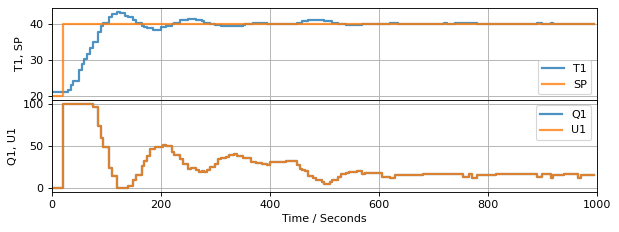

TCLab Model disconnected successfully.


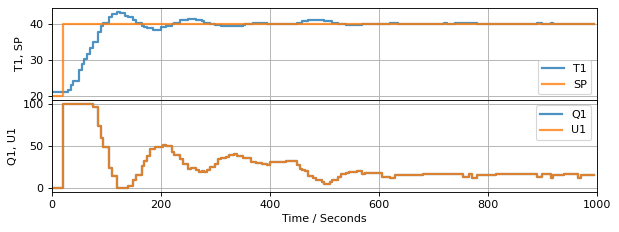

In [4]:

def PI_antiwindup_1(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    ''' PI controller with anti-windup

    This is NOT our final version of the PI controller.
    
    Arguments:  
        Kp: proportional gain
        Ki: integral gain
        MV_bar: bias (default 0)
        MV_min: minimum MV (default 0)
        MV_max: maximum MV (default 100)    

    Usage:
        controller = PI_antiwindup_1(Kp, Ki, MV_bar, MV_min, MV_max)
        t_step, SP, PV = next(controller)
        MV = controller.send([t_step, SP, PV])
    '''

    # Initialize MV with bias value (MV_bar)
    MV = MV_bar

    # Initialize previous error as 0
    e_prev = 0

    # Infinite loop
    while True:
        # Yield MV and wait for new t_step, SP, PV
        t_step, SP, PV = yield MV

        # Calculate error
        e = SP - PV

        # Adjust MV using PI velocity form
        MV = MV + Kp*(e - e_prev) + t_step*Ki*e

        # Saturate MV (apply bounds of MV_min and MV_max)
        MV = max(MV_min, min(MV_max, MV))

        # Update previous error
        e_prev = e

# Create new controller
controller = PI_antiwindup_1(Kp=10, Ki=0.5)

with TCLab() as lab:
    # Create a historian to store data
    sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
               ("U1", lambda: U1), ("Q1", lab.Q1))
    h = Historian(sources)
    p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

    # Initialize maximum heater power (recall 255 is maximum)
    lab.P1 = 200
    lab.P2 = 200

    # Apply first step of controller
    lab.Q1(next(controller))

    # event loop over time
    for t in clock(t_final, t_step):
        # Measure temperature
        T1 = lab.T1

        # Calculate control action
        U1 = controller.send((t_step, SP(t), T1))

        # Apply control action
        lab.Q1(U1)

        # Apply disturbance
        lab.Q2(DV(t))

        # Update plot
        p.update(t)
        

### Anti-reset Windup: Type 2

Another form of windup occurs when the manipulated variable is subject to external interventions. This can occur when a valve stem in a process application gets stuck, an operator or user intervenes and resets a mechanical actuator, or there is some sort of system failure. 

For these reasons, practical control systems often include a field measurement of the manipulated variable. The following image, for example, shows a pneumatically operated globe valve with a positioner, and with feedback of position to the central control system.

<p><a href="https://commons.wikimedia.org/wiki/File:Pl_control_valve.jpg#/media/File:Pl_control_valve.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Pl_control_valve.jpg" alt="Pl control valve.jpg" height="720" width="540"></a>
    
 <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>
    
Stepper motors are commonly used actuators in lab equipment and robotics. The position of the stepper motor would be manipulated variable. This is an example of a stepper motor with an integrated encoder that can be used to verify the motor's position.
    
![](https://www.portescap.com/-/media/project/automation-specialty/portescap/portescap/products/workings-of-encoders/encoder_chart_720x450_1_0.jpg)

Valve position feedback is a feature of control valves used in process applications, and should be regarded as a 'best practice' for industrial automation.

![](https://jckantor.github.io/cbe30338-2021/figures/valve-position-feedback.png)

This behavior also occurs in the Temperature Control Laboratory in which the manipulated power levels are constrained to the range 0% to 100%. This is demonstated in the following cell.

In [5]:
# show that inputs to the TCLab are constrained to the range 0 to 100%
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    print(f"Q1 = {lab.Q1()}")
    lab.Q1(150)
    print(f"Q1 = {lab.Q1()}")

TCLab version 1.0.0
Simulated TCLab
Q1 = 0
Q1 = 100
TCLab Model disconnected successfully.


To accommodate feedback of the manipulated variable, we first need to modify the event loop to incorporate the measurement of the manipulated variable, then send that value to the controller.

In [6]:
def PI_antiwindup_2(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    ''' PI controller with integral anti-windup  

    This is NOT our final version of the PI controller.

    Arugments:
        Kp: proportional gain
        Ki: integral gain
        MV_bar: bias (default 0)
        MV_min: minimum MV (default 0)
        MV_max: maximum MV (default 100)
    
    Usage:
        controller = PI_antiwindup_2(Kp, Ki, MV_bar, MV_min, MV_max)
        t_step, SP, PV = next(controller)
        MV = controller.send([t_step, SP, PV])
    '''
    # Initialize MV with bias value (MV_bar)
    MV = MV_bar

    # Initialize previous error as 0
    e_prev = 0

    # Infinite loop
    while True:
        # Yield MV and wait for new t_step, SP, PV
        # ** Now gets MV from experiment **
        t_step, SP, PV, MV = yield MV

        # Calculate error
        e = SP - PV

        # Adjust MV using PI velocity form (using MV from experiment)
        MV = MV + Kp*(e - e_prev) + t_step*Ki*e 

        # Saturate MV (apply bounds of MV_min and MV_max)
        # ** disabled for this demonstration **
        # MV = max(MV_min, min(MV_max, MV))

        # Update previous error
        e_prev = e


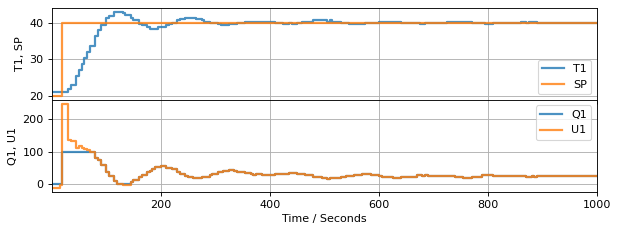

TCLab Model disconnected successfully.


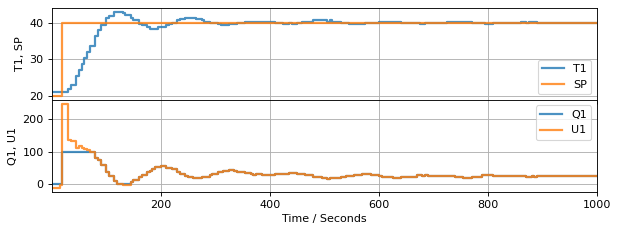

In [7]:
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=60)

# Create new controller
controller = PI_antiwindup_2(10, 0.5)

with TCLab() as lab:

    # set up historian and plotter
    sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
               ("U1", lambda: U1), ("Q1", lab.Q1))
    h = Historian(sources)
    p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

    # initialize maximum heater power (recall 255 is maximum)
    lab.P1 = 200

    # apply first step of controller
    next(controller)

    # event loop over time
    for t in clock(t_final, t_step):

        # measure temperature
        T1 = lab.T1

        # measure the control action [new line]
        U1 = lab.Q1()

        # calculate control action
        # ** now U1 (measured above) is included in the send command **
        U1 = controller.send((t_step, SP(t), T1, U1))

        # apply control action
        lab.Q1(U1)

        # apply disturbance
        lab.Q2(DV(t))

        # update plot
        p.update(t)     

The next change is to the controller. The controller now accepts values for PV, SP, and, additionally, MV. To demonstrate the impact of these changes, this example will comment out the software limits placed on MV to show that feedback of manipulated variable is also an anti-reset windwup strategy.

### Anti-Reset Windup: Complete

With these considerations in place, the following cell presents a version of the PI control algorithm incorporating both range limits and direct feedback of the manipulated variables.

In [8]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    ''' PI controller with integral anti-windup

    This is our final version of the PI controller with integral anti-windup.

    Arugments:
        Kp: proportional gain
        Ki: integral gain
        MV_bar: bias (default 0)
        MV_min: minimum MV (default 0)
        MV_max: maximum MV (default 100)
    
    Usage:
        controller = PI_antiwindup(Kp, Ki, MV_bar, MV_min, MV_max)
        t_step, SP, PV = next(controller)
        MV = controller.send([t_step, SP, PV])
    '''
    # Initialize MV with bias value (MV_bar)
    MV = MV_bar

    # Initialize previous error as 0
    e_prev = 0
    while True:

        # Yield MV and wait for new t_step, SP, PV
        # ** Now gets MV from experiment **
        t_step, SP, PV, MV = yield MV

        # Calculate error
        e = SP - PV

        # Adjust MV using PI velocity form (using MV from experiment)
        MV = MV + Kp*(e - e_prev) + t_step*Ki*e

        # Saturate MV (apply bounds of MV_min and MV_max) 
        MV = max(MV_min, min(MV_max, MV))

        # Update previous error
        e_prev = e
        

## Manual to Auto Transition: Bumpless Transfer

Manual operation can be implemented by specifying the manipulated variable. We will implement this by specifying a function that specifies values of manipulated variable whenever manual conteol is in effect. 

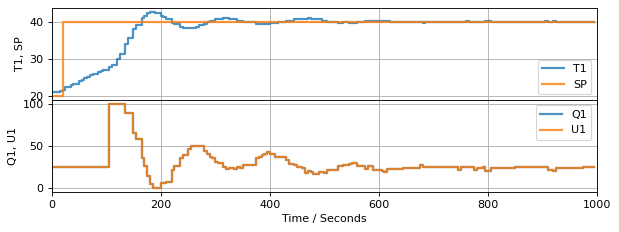

TCLab Model disconnected successfully.


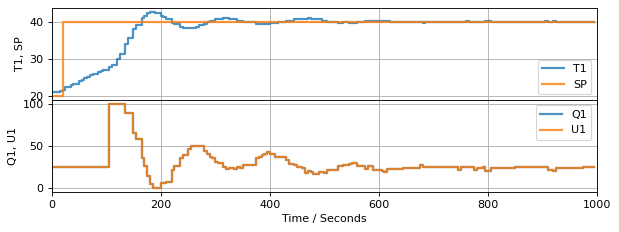

In [9]:
from tclab import TCLab, clock, Historian, Plotter, setup

def MV(t):
    ''' Manipulated variable profile 
        25% for t <= 100 seconds
        None (auto) for t > 100 seconds
    '''
    return 25 if t <= 100 else None

def experiment_3(controller):
    ''' Run experiment starting with manual control for 100 seconds
        followed by automatic control
    
    Arguments:
        controller: generator for the controller

    Details:
        Simulates experiments with the TCLab in digital twin mode

    Returns:
        None

    '''

    TCLab = setup(connected=False, speedup=60)

    with TCLab() as lab:

        # set up historian and plotter
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

        # Set maximum heater power (recall 255 is maximum)
        lab.P1 = 200

        # Apply first step of controller
        lab.Q1(next(controller))

        # event loop over time
        for t in clock(t_final, t_step):

            # Measure temperature
            T1 = lab.T1

            # Measure the control action
            U1 = lab.Q1()

            # Calculate control action
            if MV(t) is None:         
                # Automatic control  
                U1 = controller.send((t_step, SP(t), T1, U1))
            else:
                # Manual control
                U1 = MV(t)

            # Apply control action
            lab.Q1(U1)

            # Apply disturbance
            lab.Q2(DV(t))

            # Update plot
            p.update(t)  

# Create new controller
controller3a = PI_antiwindup(Kp=10, Ki=0.5)

# Run experiment
experiment_3(controller3a)

## Bumpless Transfer

* Remove setpoint from proportional term
* Only the integral control term incorporates the setpoint. 

### Bumpless Transfer

\begin{align}
e_k & = SP_k - PV_k \\
\hat{MV}_{k} & = MV_{k-1} + K_p(-PV_{k} + PV_{k-1}) + \delta t K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

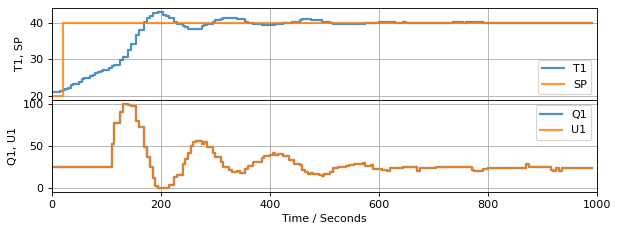

TCLab Model disconnected successfully.


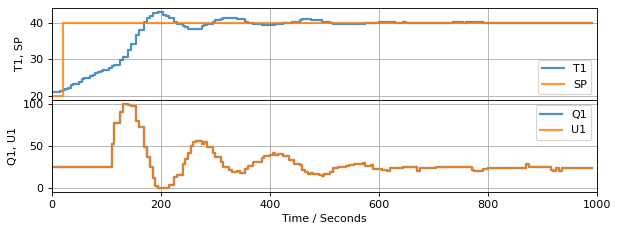

In [10]:
def PI_bumpless(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    ''' PI controller with bumpless transfer and integral anti-windup

    This is our final version of the PI controller.

    Arugments:
        Kp: proportional gain
        Ki: integral gain
        MV_bar: bias (default 0)
        MV_min: minimum MV (default 0)
        MV_max: maximum MV (default 100)

    Usage:
        controller = PI_bumpless(Kp, Ki, MV_bar, MV_min, MV_max)
        t_step, SP, PV = next(controller)
        MV = controller.send([t_step, SP, PV])

    '''

    # Initialize MV with bias value (MV_bar)
    MV = MV_bar

    # Initialize previous process variable as None
    PV_prev = None
    while True:
        # Yield MV and wait for new t_step, SP, PV
        t_step, SP, PV, MV = yield MV 

        # Calculate error
        e = SP - PV

        # Adjust MV using PI velocity form (using MV from experiment)
        # (skipped first time controller is called)
        if PV_prev is not None:
            MV += -Kp*(PV - PV_prev) + t_step*Ki*e 
            MV = max(MV_min, min(MV_max, MV))

        # Update previous process variable
        PV_prev = PV
        
experiment_3(PI_bumpless(Kp=10, Ki=0.5))

## Take Away Messages
1. Anti-windup prevents MV from saturating due to the integral term. It also uses measurements of the manipulated variable (in case the actuator gets stuck!)
2. Bumpless prevents big spikes when turning on the controller or large setpoint changes.
3. These practical details are essential for control systems in practice. Our goal in this class is to give you a mix of conceptual understanding, mathematical tools, and hands-on experience. If you work with control systems professional, please remember there are lots of important details often not in academic textbooks.